<center><b><h1>21AIE312 - Deep Learning for Signal and Image Processing</h1></b></center>
<center><b><h2>End Semester Project Presentation</h2></b></center> <br>
<center><b><h2>Detection of stages of Alzheimer’s disease using transfer learning methods</h2></b></center>

# Importing necessary packages

In [2]:
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Flatten, Activation, GlobalAveragePooling2D,Conv2D, MaxPooling2D
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.layers import RandomRotation, RandomZoom
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras import Sequential, Input, Model
from tensorflow.data.experimental import AUTOTUNE
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import applications
import tensorflow as tf

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import itertools
import random
import json
import os

import warnings
warnings.filterwarnings('ignore')

# Data Preparation

In [3]:
tf.random.set_seed(0)
dataLocation = '/kaggle/input/alzheimer-mri-dataset/Dataset'


IMG_SIZE = (128, 128)
BATCH_SIZE = 32
SEED = 0


trainData = image_dataset_from_directory(directory=dataLocation, label_mode='categorical', batch_size=BATCH_SIZE, image_size=IMG_SIZE,
                                             shuffle=True, validation_split=0.2, subset='training', seed=SEED)

validationData = image_dataset_from_directory(directory=dataLocation, label_mode='categorical', batch_size=BATCH_SIZE, image_size=IMG_SIZE,
                                                       shuffle=True, validation_split=0.2, subset='validation', seed=SEED)

classLabels = trainData.class_names
trainData = trainData.prefetch(buffer_size=AUTOTUNE)
print(f'\nThe availabe classes are : {", ".join(classLabels)}')

Found 6400 files belonging to 4 classes.
Using 5120 files for training.
Found 6400 files belonging to 4 classes.
Using 1280 files for validation.

The availabe classes are : Mild_Demented, Moderate_Demented, Non_Demented, Very_Mild_Demented


# Data Description

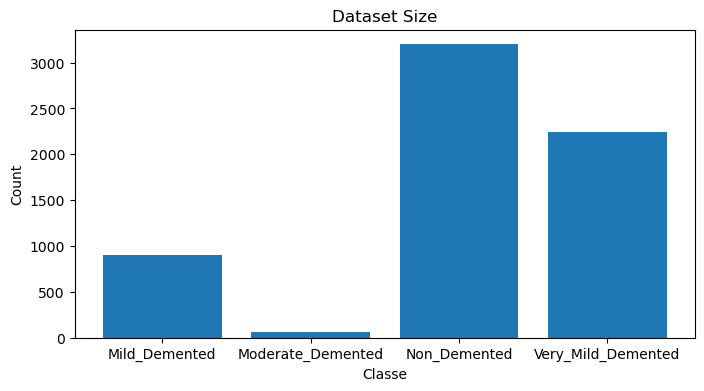

,Mild_Demented,Moderate_Demented,Non_Demented,Very_Mild_Demented
Files available,896,64,3200,2240


In [4]:
labelCount = dict()
for label in classLabels:
    labelCount[label] = len(os.listdir(dataLocation+'/'+label))

plt.figure(figsize=(8,4))
plt.bar(labelCount.keys(), labelCount.values())
plt.xlabel('Classe')
plt.ylabel('Count')
plt.title('Dataset Size')
plt.show()

display(pd.DataFrame({key:[val] for key, val in labelCount.items()}, index=['Files available']))

# Data Visualization

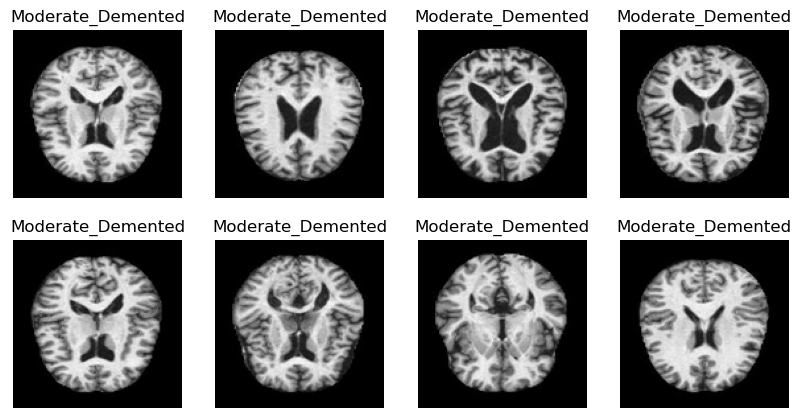

In [5]:
plt.figure(figsize=(10, 5))
for images, labels in trainData.take(1):
    for i in range(8):
        ax = plt.subplot(2, 4, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(classLabels[int(max(labels[i]))])
        plt.axis('off')

# Splitting into valid and test data


In [6]:
validBatch = len(validationData)

validData = validationData.take(validBatch // 2)
testData = validationData.skip(validBatch // 2)

print(f'Total number of validation batches : {validBatch}')
print(f'Number of batches in validation dataset : {len(validData)}')
print(f'Number of batches in test dataset : {len(testData)}')

Total number of validation batches : 40
Number of batches in validation dataset : 20
Number of batches in test dataset : 20


# Data Augumentation 

In [7]:
def data_augmentar():    
    dataAug = Sequential()
    dataAug.add(RandomRotation(factor=(-0.15, 0.15)))
    dataAug.add(RandomZoom((-0.3, -0.1)))
    return dataAug

data_augmentation = data_augmentar()

# Sample augumented image

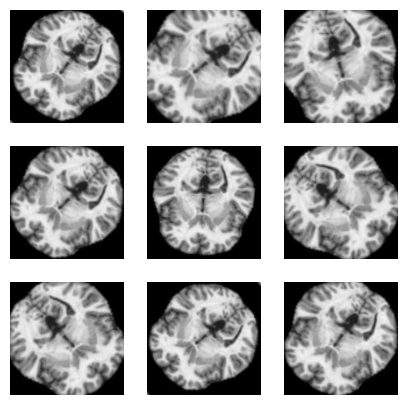

In [8]:
plt.figure(figsize=(5, 5))
for images, labels in trainData.take(1):
    image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        augmented_image = data_augmentation(image)
        plt.imshow(augmented_image.numpy().astype('uint8'), cmap='gray')
        plt.axis('off')

# Calculating weights for each class

In [20]:
total = sum(labelCount.values())

class_weights = dict()
for label in labelCount.keys():
    class_weights[label] = round(total / (4 * labelCount[label]), 2)
    print(f'Weight for the class {label, labelCount[label]} : {class_weights[label]}')

print('\n')
display(pd.DataFrame({key:[val] for key, val in class_weights.items()}, index=['Class weights']))
class_weights = {i:list(class_weights.values())[i] for i in range(len(class_weights.values()))}

Weight for the class ('Mild_Demented', 896) : 1.79
Weight for the class ('Moderate_Demented', 64) : 25.0
Weight for the class ('Non_Demented', 3200) : 0.5
Weight for the class ('Very_Mild_Demented', 2240) : 0.71




,Mild_Demented,Moderate_Demented,Non_Demented,Very_Mild_Demented
Class weights,1.79,25.0,0.5,0.71


# Training and comparing the transfer learning model

In [10]:
models = {
    'ResNet50' : [applications.resnet50.preprocess_input, applications.ResNet50(include_top=False)],
    'MobileNetV3' : [applications.mobilenet_v3.preprocess_input, applications.MobileNetV3Large(include_top=False)],
    'EfficientNet' : [applications.efficientnet.preprocess_input, applications.EfficientNetB0(include_top=False)],
    'InceptionV3' : [applications.inception_v3.preprocess_input, applications.InceptionV3(include_top=False)],
    'VGG16' : [applications.vgg16.preprocess_input, applications.VGG16(include_top=False)],
    'DenseNet' : [applications.densenet.preprocess_input, applications.DenseNet121(include_top=False)]
}

29084464/29084464 [==============================] - 0s 0us/step


In [11]:
modelDetails = {
    'ResNet50' : {},
    'MobileNetV3' : {},
    'EfficientNet' : {},
    'InceptionV3' : {},
    'VGG16' : {},
    'DenseNet' : {},
}

In [14]:
def get_model_with_preprocessed(baseModel):
    baseModel.trainable = False
    inputLayer = Input(shape=IMG_SIZE + (3,))
    x = data_augmentation(inputLayer)
    x = preprocess_input(inputLayer)
    x = baseModel(x)
    x = GlobalAveragePooling2D()(x)
    outputLayer = Dense(units=4, activation="softmax")(x)
    
    baseModel = Model(inputLayer, outputLayer)
    baseModel.compile(loss=CategoricalCrossentropy(), optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    
    return baseModel

In [28]:
def get_model_with_preprocessed_and_additionalLayers(baseModel):
    baseModel.trainable = False
    inputLayer = Input(shape=IMG_SIZE + (3,))
    x = data_augmentation(inputLayer)
    x = preprocess_input(inputLayer)
    x = baseModel(x)
    x = GlobalAveragePooling2D()(x)
    
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    x = Dense(1024)(x)
    x = Activation('relu')(x)
    x = Dense(1024)(x)
    x = Activation('relu')(x)
    
    outputLayer = Dense(units=4, activation="softmax")(x)
    
    baseModel = Model(inputLayer, outputLayer)
    baseModel.compile(loss=CategoricalCrossentropy(), optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    
    return baseModel

In [16]:
def get_model_without_preprocessed(baseModel):
    baseModel.trainable = True
    inputLayer = Input(shape=IMG_SIZE + (3,))
    x = data_augmentation(inputLayer)
    x = preprocess_input(inputLayer)
    x = baseModel(x)
    x = GlobalAveragePooling2D()(x)
    outputLayer = Dense(units=4, activation="softmax")(x)
    
    baseModel = Model(inputLayer, outputLayer)
    baseModel.compile(loss=CategoricalCrossentropy(), optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    
    return baseModel

In [29]:
def get_model_without_preprocessed_and_additionalLayers(baseModel):
    baseModel.trainable = True
    inputLayer = Input(shape=IMG_SIZE + (3,))
    x = data_augmentation(inputLayer)
    x = preprocess_input(inputLayer)
    x = baseModel(x)
    x = GlobalAveragePooling2D()(x)
    
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    x = Dense(1024)(x)
    x = Activation('relu')(x)
    x = Dense(1024)(x)
    x = Activation('relu')(x)
    
    outputLayer = Dense(units=4, activation="softmax")(x)
    
    baseModel = Model(inputLayer, outputLayer)
    baseModel.compile(loss=CategoricalCrossentropy(), optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    
    return baseModel

In [18]:
earlystopping = EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 0)
callbacks = [earlystopping]

In [19]:
for modelName, modelSpec in models.items():
    preprocess_input, current_model = modelSpec[0], modelSpec[1]
    baseModel = current_model
    
    print(f'[LOG] Starting training of {modelName} with pre-calculated weights.')
    model_01 = get_model_with_preprocessed(baseModel)
    model_01_History = model_01.fit(trainData,validation_data=validData, epochs=50, class_weight=class_weights, callbacks=callbacks, use_multiprocessing=True, verbose=0) 
    model_01_loss, model_01_acc =   model_01.evaluate(testData, verbose=0)
    print(f'[LOG] Finished training of {modelName} with pre-calculated weights [Epoch - {len(model_01_History.epoch)}].')
    
    print(f'[LOG] Starting training of {modelName} with pre-calculated weights and additional layers.')
    model_02 = get_model_with_preprocessed_and_additionalLayers(baseModel)
    model_02_History = model_02.fit(trainData,validation_data=validData, epochs=50, class_weight=class_weights, callbacks=callbacks, use_multiprocessing=True, verbose=0) 
    model_02_loss, model_02_acc =   model_02.evaluate(testData, verbose=0)
    print(f'[LOG] Finished training of {modelName} with pre-calculated weights and additional layers [Epoch - {len(model_02_History.epoch)}].')
    
    print(f'[LOG] Starting training of {modelName} without pre-calculated weights.')
    model_03 = get_model_without_preprocessed(baseModel)
    model_03_History = model_03.fit(trainData,validation_data=validData, epochs=50, class_weight=class_weights, callbacks=callbacks, use_multiprocessing=True, verbose=0) 
    model_03_loss, model_03_acc =   model_03.evaluate(testData, verbose=0)
    print(f'[LOG] Finished training of {modelName} without pre-calculated weights [Epoch - {len(model_03_History.epoch)}].')
    
    print(f'[LOG] Starting training of {modelName} without pre-calculated weights and additional layers.')
    model_04 = get_model_without_preprocessed_and_additionalLayers(baseModel)
    model_04_History = model_04.fit(trainData,validation_data=validData, epochs=50, class_weight=class_weights, callbacks=callbacks, use_multiprocessing=True, verbose=0) 
    model_04_loss, model_04_acc =   model_04.evaluate(testData, verbose=0)
    print(f'[LOG] Finished training of {modelName} without pre-calculated weights and additional layers [Epoch - {len(model_04_History.epoch)}].')
    
    modelDetails[modelName]['with_pre_weights'] = {'loss' : model_01_loss, 'accuracy' : model_01_acc, 'epoch' : len(model_01_History.epoch), 'model': model_01}
    modelDetails[modelName]['with_pre_weights_and_additional_layers'] = {'loss' : model_02_loss, 'accuracy' : model_03_acc, 'epoch' : len(model_02_History.epoch), 'model': model_02}
    modelDetails[modelName]['without_pre_weights'] = {'loss' : model_03_loss, 'accuracy' : model_03_acc, 'epoch' : len(model_03_History.epoch), 'model': model_03}
    modelDetails[modelName]['without_pre_weights_and_additional_layers'] = {'loss' : model_04_loss, 'accuracy' : model_04_acc, 'epoch' : len(model_04_History.epoch), 'model': model_04}
    
    print('\n')

[LOG] Starting training of ResNet50 with pre-calculated weights.
[LOG] Finished training of ResNet50 with pre-calculated weights [Epoch - 13].
[LOG] Starting training of ResNet50 with pre-calculated weights and additional layers.
[LOG] Finished training of ResNet50 with pre-calculated weights and additional layers [Epoch - 31].
[LOG] Starting training of ResNet50 without pre-calculated weights.
[LOG] Finished training of ResNet50 without pre-calculated weights [Epoch - 13].
[LOG] Starting training of ResNet50 without pre-calculated weights and additional layers.
[LOG] Finished training of ResNet50 without pre-calculated weights and additional layers [Epoch - 10].


[LOG] Starting training of MobileNetV3 with pre-calculated weights.
[LOG] Finished training of MobileNetV3 with pre-calculated weights [Epoch - 26].
[LOG] Starting training of MobileNetV3 with pre-calculated weights and additional layers.
[LOG] Finished training of MobileNetV3 with pre-calculated weights and additional layer

2023-06-27 06:44:58.864217: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_8/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


[LOG] Finished training of EfficientNet with pre-calculated weights [Epoch - 22].
[LOG] Starting training of EfficientNet with pre-calculated weights and additional layers.


2023-06-27 06:46:50.203103: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_9/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


[LOG] Finished training of EfficientNet with pre-calculated weights and additional layers [Epoch - 9].
[LOG] Starting training of EfficientNet without pre-calculated weights.


2023-06-27 06:47:51.594247: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_10/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


[LOG] Finished training of EfficientNet without pre-calculated weights [Epoch - 19].
[LOG] Starting training of EfficientNet without pre-calculated weights and additional layers.


2023-06-27 06:53:42.618198: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_11/efficientnetb0/block2b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


[LOG] Finished training of EfficientNet without pre-calculated weights and additional layers [Epoch - 8].


[LOG] Starting training of InceptionV3 with pre-calculated weights.
[LOG] Finished training of InceptionV3 with pre-calculated weights [Epoch - 10].
[LOG] Starting training of InceptionV3 with pre-calculated weights and additional layers.
[LOG] Finished training of InceptionV3 with pre-calculated weights and additional layers [Epoch - 16].
[LOG] Starting training of InceptionV3 without pre-calculated weights.
[LOG] Finished training of InceptionV3 without pre-calculated weights [Epoch - 14].
[LOG] Starting training of InceptionV3 without pre-calculated weights and additional layers.
[LOG] Finished training of InceptionV3 without pre-calculated weights and additional layers [Epoch - 13].


[LOG] Starting training of VGG16 with pre-calculated weights.
[LOG] Finished training of VGG16 with pre-calculated weights [Epoch - 16].
[LOG] Starting training of VGG16 with pre-calculated weig

In [23]:
tempData = {}
for i in modelDetails.keys():
    tempData[i] = {}
    for j in modelDetails[i].keys():
        tempData[i][j] = modelDetails[i][j]

for i in tempData.keys():
    for j in tempData[i].keys():
        tempData[i][j].pop('model')

In [ ]:
with open("DL_team_08_results_v1.json", "w") as outfile:
    json.dump(tempData, outfile)

In [21]:
pd.DataFrame(modelDetails)

,ResNet50,MobileNetV3,EfficientNet,InceptionV3,VGG16,DenseNet
with_pre_weights,"{'loss': 0.910683274269104, 'accuracy': 0.6015...","{'loss': 0.7072888612747192, 'accuracy': 0.673...","{'loss': 0.8610731959342957, 'accuracy': 0.621...","{'loss': 0.9024152755737305, 'accuracy': 0.585...","{'loss': 0.8915465474128723, 'accuracy': 0.600...","{'loss': 0.9705361127853394, 'accuracy': 0.542..."
with_pre_weights_and_additional_layers,"{'loss': 0.7449044585227966, 'accuracy': 0.864...","{'loss': 0.5916550159454346, 'accuracy': 0.310...","{'loss': 1.0457141399383545, 'accuracy': 0.779...","{'loss': 0.8753234148025513, 'accuracy': 0.623...","{'loss': 1.0239360332489014, 'accuracy': 0.464...","{'loss': 1.0266878604888916, 'accuracy': 0.673..."
without_pre_weights,"{'loss': 0.38871461153030396, 'accuracy': 0.86...","{'loss': 7.156469821929932, 'accuracy': 0.3109...","{'loss': 0.8399953842163086, 'accuracy': 0.779...","{'loss': 1.1693687438964844, 'accuracy': 0.623...","{'loss': 1.3801008462905884, 'accuracy': 0.464...","{'loss': 0.8200065493583679, 'accuracy': 0.673..."
without_pre_weights_and_additional_layers,"{'loss': 0.7065397500991821, 'accuracy': 0.673...","{'loss': 113.949462890625, 'accuracy': 0.60937...","{'loss': 0.4423602521419525, 'accuracy': 0.856...","{'loss': 3.9103808403015137, 'accuracy': 0.254...","{'loss': 1.3786519765853882, 'accuracy': 0.150...","{'loss': 3.714895725250244, 'accuracy': 0.0140..."


In [22]:
a = modelDetails.copy()

In [ ]:
b = {}
for i in a.keys():
    b[i+ ' | Accuracy (%)'] = {}
    for j in a[i].keys():
        b[i + ' | Accuracy (%)'][j] = round(list(a[i][j][1], 2)
    
c = pd.DataFrame(b)

In [25]:
a['ResNet50'].keys()

dict_keys(['with_pre_weights', 'with_pre_weights_and_additional_layers', 'without_pre_weights', 'without_pre_weights_and_additional_layers'])

In [27]:
display(c)

,ResNet50 | Accuracy (%),MobileNetV3 | Accuracy (%),EfficientNet | Accuracy (%),InceptionV3 | Accuracy (%),VGG16 | Accuracy (%),DenseNet | Accuracy (%)
with_pre_weights,0.60,0.67,0.62,0.59,0.60,0.54
with_pre_weights_and_additional_layers,0.86,0.31,0.78,0.62,0.46,0.67
without_pre_weights,0.86,0.31,0.78,0.62,0.46,0.67
without_pre_weights_and_additional_layers,0.67,0.61,0.86,0.25,0.15,0.01
